# 1D GAN - 28/11/19

A generative Adversarial Network to reproduce S1 from G4DS. THis script is created to allow us to mess around slightly with the data and layers, with all the runs included. THis allows us to quickly check the versaility of one set of layers for the different distributions.

We were looking at ene0 and trying to interpret it. This ended up not being useful to us, as we we can literally extract the energy from the G4DS setup

In [12]:
pip install uproot

In [13]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
ls

1D_model.h5                   dark_matter_runs_200kev.root
2D_s1_s2_5IN.h5               dark_matter_runs_50kev.log
2D_s1_s2.h5                   dark_matter_runs_50kev.root
3D_s1_s2_f200.h5              dark_matter_runs_75kev.root
dark_matter_100kev_v1.log     d.png
dark_matter_100kev_v1.root    g.png
dark_matter_runs_125kev.root  logs/
dark_matter_runs_150kev.log   model_plot.png
dark_matter_runs_200kev.log   model.png


In [15]:
cd gdrive/My\ Drive/Masters_Project/dark_matter_7_12_19

[Errno 2] No such file or directory: 'gdrive/My Drive/Masters_Project/dark_matter_7_12_19'
/content/gdrive/My Drive/dark_matter_7_12_19


Import relevant libraries & use uproot to open it.

In [0]:
import uproot
import pandas
import numpy as np
import matplotlib.pyplot as plt

tree50 = uproot.open("dark_matter_runs_50kev.root")["dstree"]
tree100 = uproot.open("dark_matter_100kev_v1.root")["dstree"]
tree150 = uproot.open("dark_matter_runs_125kev.root")["dstree"]

The different variables contained within the tree.

In [17]:
tree50.show()

ev                         (no streamer)              asdtype('>i4')
pdg                        (no streamer)              asdtype('>i4')
ene0                       (no streamer)              asdtype('>f4')
s1ene                      (no streamer)              asdtype('>f4')
s2ene                      (no streamer)              asdtype('>f4')
veto_visene                (no streamer)              asdtype('>f4')
mu_visene                  (no streamer)              asdtype('>f4')
vetoene                    (no streamer)              asdtype('>f4')
muene                      (no streamer)              asdtype('>f4')
tpcene                     (no streamer)              asdtype('>f4')
x                          (no streamer)              asdtype('>f4')
y                          (no streamer)              asdtype('>f4')
z                          (no streamer)              asdtype('>f4')
ene                        (no streamer)              asdtype('>f4')
r                          (no str

Training Dataset is the x variable.

In [0]:
var = "s1_corr"
rangemin = 0
rangemax = 600
resolution = 5
binnum = int((rangemax - rangemin)/resolution)
train_DS = np.array(tree50.array(f"{var}"))

e50_s1 = np.array(tree50.array("s1_corr"))
e50_s2 = np.array(tree50.array("s2"))
e50_ene0 = np.array(tree50.array("ene0"))

e100_s1 = np.array(tree100.array("s1_corr"))
e100_s2 = np.array(tree100.array("s2"))
e100_ene0 = np.array(tree100.array("ene0"))

e150_s1 = np.array(tree150.array("s1_corr"))
e150_s2 = np.array(tree150.array("s2"))
e150_ene0 = np.array(tree150.array("ene0"))

In [0]:
mean_e50_s1 = np.mean(np.array(tree50.array("s1_corr")))
mean_e50_s2 = np.mean(np.array(tree50.array("s2")))
mean_e50_ene0 = np.mean(np.array(tree50.array("ene0")))

mean_e100_s1 = np.mean(np.array(tree100.array("s1_corr")))
mean_e100_s2 = np.mean(np.array(tree100.array("s2")))
mean_e100_ene0 = np.mean(np.array(tree100.array("ene0")))

mean_e150_s1 = np.mean(np.array(tree150.array("s1_corr")))
mean_e150_s2 = np.mean(np.array(tree150.array("s2")))
mean_e150_ene0 = np.mean(np.array(tree150.array("ene0")))



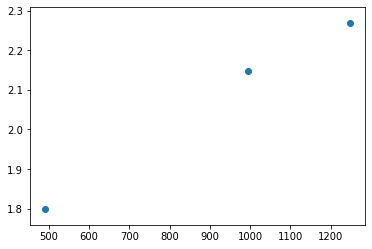

In [20]:
x = [mean_e50_s1,mean_e100_s1,mean_e150_s1]
y = [np.log(mean_e50_s2/mean_e50_s1),np.log(mean_e100_s2/mean_e100_s1),np.log(mean_e150_s2/mean_e150_s1)]

plt.scatter(x,y)


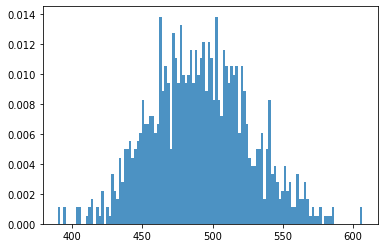

In [21]:
#maxi = train_DS.max()
maxi = 1
train_DS = train_DS/maxi
e_50 = plt.hist(train_DS,  density = True, bins = binnum, alpha = 0.8)

In [22]:
len(train_DS)

1000

In [0]:
num_train = len(train_DS)
noise_size = 1000

In [0]:
#  Model dependent constants
#  Define model PDF

#The range of the model
range_min, range_max = 0, 1
#The range being plot
range_width = range_max - range_min

plot_resolution = 200

#Initial weights
w1, m1, s1 = 0.5, 8., 1.
w2, m2, s2 = 0.5, 14, 5.

In [0]:
#  Create GAN

from tensorflow.keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.models     import Model, Sequential
from tensorflow.keras.optimizers import Adam

#Discriminator
#See how number of neurons are sae for each layer to reduce number of hyperparameters
d = Sequential(name="Discriminator")
d.add(Dense(100, activation="relu", input_shape=(1,)))
#d.add(BatchNormalization())
d.add(Dense(100, activation="relu"))
#d.add(LeakyReLU(0.2))
d.add(Dense(2, activation="softmax"))
d.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.9), metrics=["accuracy"])
d.summary()

g = Sequential(name="Generator")
g.add(Dense(100, activation="relu", input_shape=(noise_size,)))
g.add(BatchNormalization())
g.add(Dense(100, activation="relu"))

g.add(Dense(1, activation="linear"))
g.summary()

input_layer = Input((noise_size,))
output_layer = d(g(input_layer))
gan = Model(input_layer, output_layer)
d.trainable = False
gan.compile(loss="categorical_crossentropy", optimizer=Adam(0.0002, beta_1=0.5), metrics=["accuracy"])
gan.summary()

In [0]:
#  Train GAN

epochs     = 15000
batch_size = 1000
max_D_itrs_per_G_itr_e70 = 4
max_D_itrs_per_G_itr_e52 = 3

train_median, train_std = np.median(train_DS), np.std(train_DS)
quantiles = np.array([.25, .75])
train_quantiles = np.quantile(train_DS, quantiles) - train_median

def update_batch_size (gen_DS) :
    global batch_size
    gen_median, gen_std = np.median(gen_DS.flatten()), np.std(gen_DS.flatten())
    if np.fabs((gen_median-train_median)/train_std) > 1./np.sqrt(batch_size) : return
    if np.fabs((gen_std/train_std)-1) > 1./np.sqrt(batch_size) : return
    '''if batch_size > 200 :
        gen_quantiles = np.quantile(gen_DS, quantiles) - gen_median
        for gen_q, train_q in zip(gen_quantiles, train_quantiles) :
            if np.fabs((gen_q/train_q)-1) > 1./np.sqrt(batch_size) : return'''
    batch_size = min(100+batch_size, num_train)
    
    epochs_saved = []



In [0]:
epochs_saved = []
gen_loss = []
gen_acc = []
real_loss = []
real_acc = []
generator_loss = []

epoch_no = []
for e in range(epochs) :
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    
    #Get the real and fake data
    batch_DS = train_DS[np.random.randint(0, len(train_DS), batch_size)].reshape(batch_size, 1)
    #fake data made from predicting noise
    #print(batch_DS)
    gen_DS   = g.predict(noise)
    
    #Real data has label [1.,0]
    real_label = np.array([[1., 0.] for i in range(batch_size)])
    
    #Fake data has label [0.,1.]
    fake_label = np.array([[0., 1.] for i in range(batch_size)])
    
    #Combine real and generated data
    X = np.concatenate([batch_DS  , gen_DS    ])
    Y = np.concatenate([real_label, fake_label])
    
    
    d.trainable = True
    d_loss, d_acc = d.train_on_batch(X, Y)
    ##d1_loss, d1_acc = d.train_on_batch(batch_DS, real_label)
    ##d2_loss, d2_acc = d.train_on_batch(gen_DS,fake_label)
    #num_itr = 0
    #while num_itr < max_D_itrs_per_G_itr_e70 and d_acc < 0.7 :
    #    d_loss, d_acc = d.train_on_batch(X, Y)
    #    num_itr = num_itr + 1
    #while num_itr < max_D_itrs_per_G_itr_e52 and d_acc < 0.52 :
    #    d_loss, d_acc = d.train_on_batch(X, Y)
    #    num_itr = num_itr + 1
        
    noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
    d.trainable = False
    #g_loss = gan.train_on_batch(noise, real_label)
    
    if e == 0 or (e+1) % 100 == 0 :
        noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
        gen_DS = g.predict(noise)
        epoch_no.append(e+1)
        s_true = plt.hist(train_DS*maxi,range = (rangemin*maxi,rangemax*maxi),  density = True, bins = binnum, alpha = 0.8, label = "G4")
        s_gen = plt.hist(gen_DS*maxi,range = (rangemin*maxi,rangemax*maxi),  density = True, bins = binnum, alpha = 0.8, label = "GAN")
        plt.legend(loc="upper right", fontsize=10)
        plt.xlabel(f"{var}", size=14, labelpad=10)
        plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")

        plt.title(f"Comparison of {var} created by the GAN and G4")
        plt.show()

        real_loss.append(d_loss)
        real_acc.append(d_acc)
        #gen_loss.append(d1_loss)
        #gen_acc.append(d1_acc)
        #generator_loss.append(g_loss)


        epochs_saved.append(e+1)


Plotting Discriminator Accuracy

In [0]:
h3 = plt.plot(epoch_no,real_loss, color = 'blue', label = "Loss")
h4 = plt.plot(epoch_no,real_acc, color = 'orange', label = "Accuracy")
plt.xlabel("Epoch number", size=14, labelpad=10)
plt.ylabel("Accuracy/Loss", size=14, labelpad=30, rotation="vertical")
plt.title(f"Disciminator variables with batch size {batch_size}")
plt.legend(loc="upper right", fontsize=10)
plt.show()

In [0]:
batch_size=num_train
noise  = np.random.uniform(low = 0, high = 1, size=(batch_size, noise_size))
gen_DS = g.predict(noise)
#s_true = plt.hist(train_DS*maxi,range = (rangemin*maxi,rangemax*maxi),  density = True, bins = binnum, alpha = 0.8, label = "G4")
#s_gen = plt.hist(gen_DS*maxi,range = (rangemin*maxi,rangemax*maxi),  density = True, bins = binnum, alpha = 0.8, label = "GAN")
s_true = plt.hist(train_DS*maxi,range = (0,400),  density = True, bins = binnum, alpha = 0.8, label = "G4")
s_gen = plt.hist(gen_DS*maxi,range = (0,400),  density = True, bins = binnum, alpha = 0.8, label = "GAN")
plt.xlabel(f"{var}", size=14, labelpad=10)
plt.ylabel(r"$\rho\left(x\right)$", size=14, labelpad=30, rotation="horizontal")
plt.title(f"Comparison of {var} created by the GAN and G4")
plt.legend(loc="upper right", fontsize=10)
s_diff = s_true[0] - s_gen[0]

sum_s_diff = 0
for i in range(len(s_diff)):
  sum_s_diff += abs(s_diff[i])

loss = sum_s_diff
print(sum_s_diff)
plt.show()